In [338]:
### Encoding model for iEEG
# Pedro Pinheiro-Chagas
# Adapted from Christopher Holdgraf's git repo: 
#(https://github.com/choldgraf/paper-encoding_decoding_electrophysiology)

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from modelingtools import delay_time_series, plot_activity_on_brain

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier





/Users/pinheirochagas/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### 1. The data
Task: MMR - calculation, memory verification and "rest" ('17+5=23', 'I ate fruit today'). <br />
Type of data: epoched and baseline corrected, all concatenated. <br />
Brain feature: Normalized HFB power.  <br />

Stimuli features:
0. Task, trial, time, block
1. Task
    - condition(calculation, memory, rest) 
    - type (active, passive)
2. Calculation specs
    - number_format (digit, word, dot)
    - operand_1
    - operand_2
    - operand_min
    - operand_max
    - operation (addition, subtraction, multiplication)
    - ls_sl
    - result 
    - cross_decade
    - presented_result
    - abs_deviant
    - number of digits
3. Memory specs
    - memory type (autobio, self-external, self-internal, fact)
4. Behavior
    - RT
    - Accuracy
    - RT_lock
    
The features were already selected and the encoding matrix was consctructed in Matlab and saved as csv.

#### Plot examplar encoding matrix:

(-0.5, 7816.5, 2741.5, -0.5)

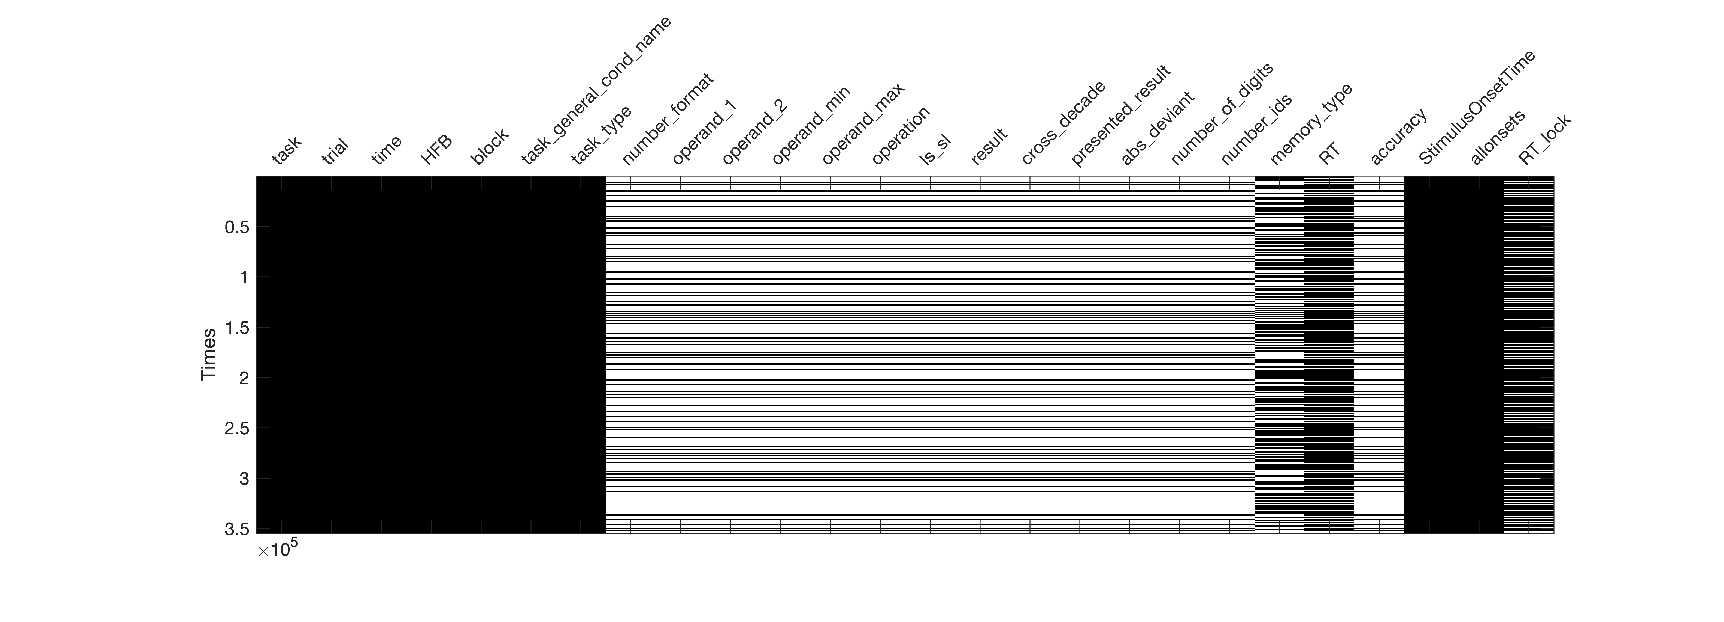

In [2]:
im = plt.imread('/Users/pinheirochagas/Pedro/Stanford/code/lbcn_encoding_decoding/figures/encoding_matrix.png') 
fig, ax = plt.subplots(figsize=(30, 15))
ax.imshow(im)
plt.axis('off')

### Load the data



In [3]:
data = np.genfromtxt('/Users/pinheirochagas/Pedro/Stanford/code/lbcn_encoding_decoding/data/data.csv', delimiter=',')

### Plot all blocks concatenated

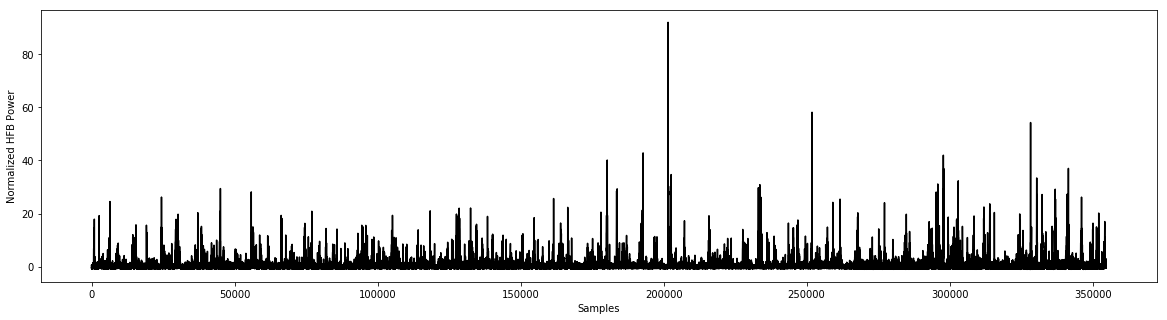

In [4]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(data[:,3], color='k')
plt.xlabel('Samples')
plt.ylabel('Normalized HFB Power')
plt.rcParams.update({'font.size': 20})

### Plot blocks saparated

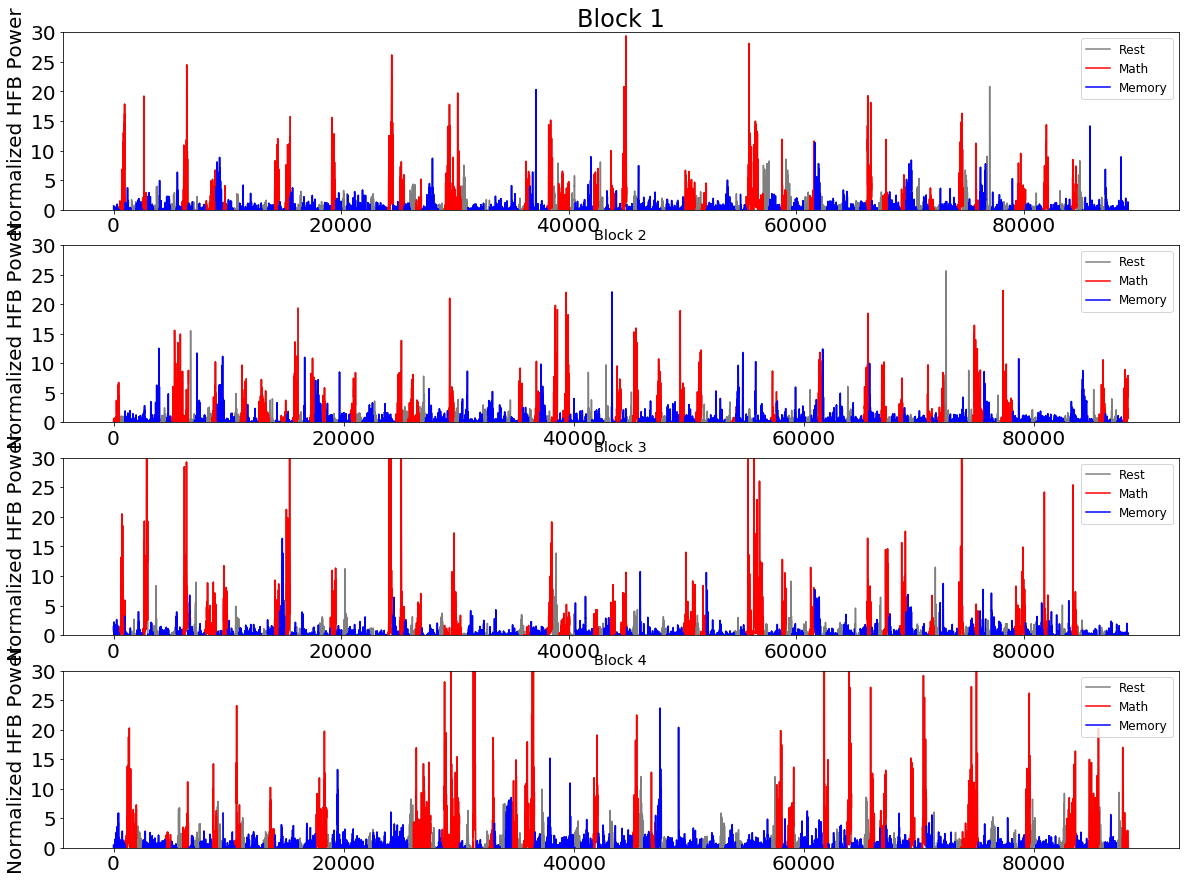

In [5]:
n_blocks = np.int(np.max(data[:,4]))
fig, ax = plt.subplots(n_blocks,1,figsize=(20, 15))

# Filter trials
math_trials = np.copy(data[:,3])
math_trials[data[:,5]!=4] = np.nan
memo_trials = np.copy(data[:,3])
memo_trials[data[:,5]!=6] = np.nan

for i in range(n_blocks):
    #ax[i].plot(samples[data[:,4]==i+1], data[data[:,4]==i+1,3])
    ax[i].plot(data[data[:,4]==i+1,3], color=[0.5,0.5,0.5], label="Rest")
    ax[i].plot(math_trials[data[:,4]==i+1], 'r', label="Math")
    ax[i].plot(memo_trials[data[:,4]==i+1], 'b', label="Memory")
    ax[i].set_ylim([0,30])
    ax[i].set_title('Block ' + str(i+1))
    #ax[i].set_xlabel('Samples')
    ax[i].set_ylabel('Normalized HFB Power')
    plt.rcParams.update({'font.size': 12}) 
    ax[i].legend()


In [6]:
features = data[:,14]
times = np.shape(np.unique(data[:,2]))
times = int(times[0])
r,c = np.shape(data)
trials = int(r/times)

In [7]:
features_reshape = np.reshape(features, (trials, times))
np.shape(features_reshape)
features_reshape = np.expand_dims(features_reshape, axis=1)
np.shape(features_reshape)

(708, 1, 501)

In [8]:
delays = np.linspace(-0.5, 0., 20)
X_delayed = delay_time_series(features_reshape, delays, 500)

In [9]:
np.shape(X_delayed)

(708, 1, 20, 501)

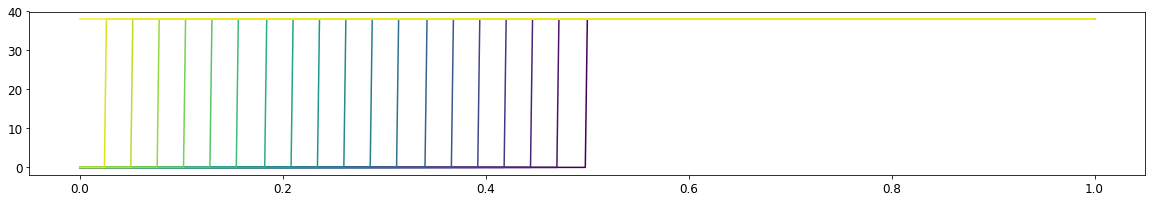

In [10]:
fig, ax = plt.subplots(figsize=(20, 3))
colors = plt.cm.viridis(np.linspace(0,1,20))

for i in range(20):
    #ax[i].plot(samples[data[:,4]==i+1], data[data[:,4]==i+1,3])
    ax.plot(np.unique(data[:,2]), np.squeeze(X_delayed[1,0,i,:]), color=colors[i])

Text(0.5,1,'Time-Delayed Task Name')

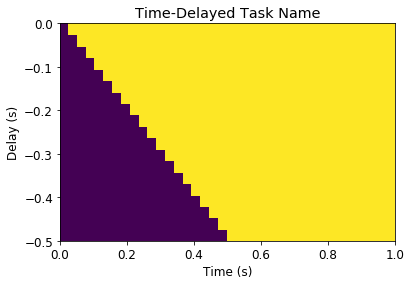

In [11]:
times = np.unique(data[:,2])
fig, ax = plt.subplots()
ax.pcolormesh(times, delays,
              X_delayed[1,0,:,:], cmap='viridis')
ax.axis('tight')
ax.set_ylabel('Delay (s)')
ax.set_xlabel('Time (s)')
ax.set_title('Time-Delayed Task Name')

In [12]:
# Concatenate back the delayed features
X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
X_env = np.hstack(X_env).T

In [13]:
# Define the dependent variable
y = data[:,3] # HFB

In [14]:
# Fit the model
est_result = make_pipeline(StandardScaler(), LinearRegression())
est_result.fit(X_env, y)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [16]:
# Choose another feature
times = np.shape(np.unique(data[:,2]))
times = int(times[0])

feature_min = data[:,5]

feature_min_reshape = np.reshape(feature_min, (trials, times))
feature_min_reshape = np.expand_dims(feature_min_reshape, axis=1)
X_delayed_min = delay_time_series(feature_min_reshape, delays, 500)
X_env_min = X_delayed_min.reshape([X_delayed_min.shape[0], -1, X_delayed_min.shape[-1]])
X_env_min = np.hstack(X_env_min).T

est_min = make_pipeline(StandardScaler(), LinearRegression())
est_min.fit(X_env_min, y)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [330]:
# Choose another feature
times = np.shape(np.unique(data[:,2]))
times = int(times[0])

features = data[:,15]

features_reshape = np.reshape(features, (trials, times))
features_reshape = np.expand_dims(features_reshape, axis=1)
X_delayed = delay_time_series(features_reshape, delays, 500)
X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
X_env = np.hstack(X_env).T

est_cd = make_pipeline(StandardScaler(), LinearRegression())
est_cd.fit(X_env, y)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [333]:
# Choose another feature
times = np.shape(np.unique(data[:,2]))
times = int(times[0])

features = data[:,15]

features_reshape = np.reshape(features, (trials, times))
features_reshape = np.expand_dims(features_reshape, axis=1)
X_delayed = delay_time_series(features_reshape, delays, 500)
X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
X_env = np.hstack(X_env).T

est_task = make_pipeline(StandardScaler(), LinearRegression())
est_task.fit(X_env, y)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

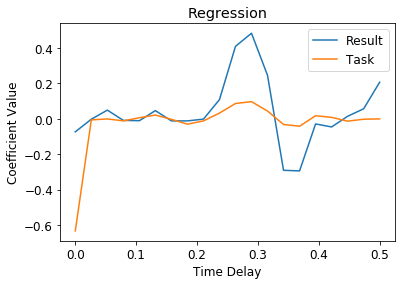

In [18]:
# Plot results
fig, ax = plt.subplots()
ax.plot(np.abs(delays), est_result.steps[-1][-1].coef_, label = 'Result')
ax.plot(np.abs(delays), est_min.steps[-1][-1].coef_,label = 'Task')
#ax.plot(np.abs(delays), est_cd.steps[-1][-1].coef_,label = 'Cross decade')
#ax.plot(np.abs(delays), est_task.steps[-1][-1].coef_,label = 'Task')

ax.set_xlabel('Time Delay')
ax.set_ylabel('Coefficient Value')
ax.set_title('Regression')
ax.legend()

In [337]:
features

array([0., 0., 0., ..., 1., 1., 1.])